In [1]:
import multiprocessing
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchio as tio
from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import *
from scripts.load_data import *
from scripts.train import *
from scripts.extract_ROI import extract_ROI 

from miseval import evaluate


seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True, warn_only=True)

num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)

/home/ids/mahdi-22/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run on Fri Jul 14 19:34:39 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [2]:
# We take a percentage of the data for training:
def split_training_data(metadata, train_ratio=0.8, vendor='A', save=False):
    n_total = metadata["Vendor"].value_counts()[vendor]
    n_train = int(n_total * train_ratio)
    indices = metadata.index[metadata["Vendor"] == vendor].tolist()
    train_indices = random.sample(indices, n_train)

    metadata.loc[train_indices, "Vendor"] = 'F'
    metadata.loc[train_indices, "Centre"] = 6

    print(f"total number of samples: {n_total}, train samples: {n_train}, Validation: {n_total-n_train}")
    if save:
        metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
        metadata.to_csv(metadata_path, index=False)
    
    return metadata

In [3]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata = split_training_data(metadata, train_ratio=0.8)
metadata.head(5)

total number of samples: 95, train samples: 76, Validation: 19


,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,F,6,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,F,6,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


In [4]:
vendors = list(metadata.Vendor.unique())
vendors

['F', 'B', 'A', 'D', 'C']

In [5]:
padding_size = 10
crop_size = 128

In [63]:
data_dir = "Data_original/OpenDataset/Training/Labeled/"
destination_dir = "Data/M&Ms/OpenDataset/Labeled/"
extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size ,padding_size=padding_size)

Start


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [03:56<00:00,  1.58s/it]

Complete


In [64]:
data_dir = "Data_original/OpenDataset/Testing/"
destination_dir = "Data/M&Ms/OpenDataset/Testing/"
extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size ,padding_size=padding_size)

Start


 63%|██████▎   | 86/136 [02:59<02:03,  2.47s/it]/home/ids/mahdi-22/.venv/lib/python3.10/site-packages/torchio/data/image.py:602: UserWarning: Error loading image with SimpleITK:
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/NIFTI/src/itkNiftiImageIO.cxx:2016:
ITK ERROR: ITK only supports orthonormal direction cosines.  No orthonormal definition found!

Trying NiBabel...
  tensor, affine = self.reader(path)
 64%|██████▍   | 87/136 [03:00<01:37,  2.00s/it]

E3F5U2  cannot be loaded


 85%|████████▌ | 116/136 [04:07<00:28,  1.44s/it]/home/ids/mahdi-22/.venv/lib/python3.10/site-packages/torchio/data/image.py:602: UserWarning: Error loading image with SimpleITK:
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/NIFTI/src/itkNiftiImageIO.cxx:2016:
ITK ERROR: ITK only supports orthonormal direction cosines.  No orthonormal definition found!

Trying NiBabel...
  tensor, affine = self.reader(path)
 86%|████████▌ | 117/136 [04:08<00:22,  1.21s/it]

C8O0P2  cannot be loaded


100%|██████████| 136/136 [04:51<00:00,  2.14s/it]

Complete


In [65]:
data_dir = "Data_original/OpenDataset/Validation/"
destination_dir = "Data/M&Ms/OpenDataset/Validation/"
extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size ,padding_size=padding_size)

Start


 88%|████████▊ | 30/34 [00:53<00:06,  1.57s/it]/home/ids/mahdi-22/.venv/lib/python3.10/site-packages/torchio/data/image.py:602: UserWarning: Error loading image with SimpleITK:
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/NIFTI/src/itkNiftiImageIO.cxx:2016:
ITK ERROR: ITK only supports orthonormal direction cosines.  No orthonormal definition found!

Trying NiBabel...
  tensor, affine = self.reader(path)
 91%|█████████ | 31/34 [00:53<00:04,  1.33s/it]

C8J7L5  cannot be loaded


100%|██████████| 34/34 [00:59<00:00,  1.76s/it]

Complete


In [6]:
transform = tio.RescaleIntensity((0, 1))
vendor_datasets_3D = []
for vendor in vendors:
    vendor_datasets_3D.append(load_vendor_3D(vendor, metadata, transform))

0it [00:00, ?it/s]

317it [00:11, 28.31it/s]


Data/M&Ms/OpenDataset/ Dataset size: 76 subjects


317it [00:16, 19.64it/s]


Data/M&Ms/OpenDataset/ Dataset size: 125 subjects


317it [00:02, 124.95it/s]


Data/M&Ms/OpenDataset/ Dataset size: 19 subjects


317it [00:06, 46.91it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 50 subjects


317it [00:06, 50.95it/s] 

Data/M&Ms/OpenDataset/ Dataset size: 47 subjects


Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 11); spacing: (0.99, 0.85, 8.00); orientation: LIP+; dtype: torch.FloatTensor; memory: 1.4 MiB)
LabelMap(shape: (2, 128, 128, 11); spacing: (0.99, 0.85, 8.00); orientation: LIP+; dtype: torch.FloatTensor; memory: 1.4 MiB)


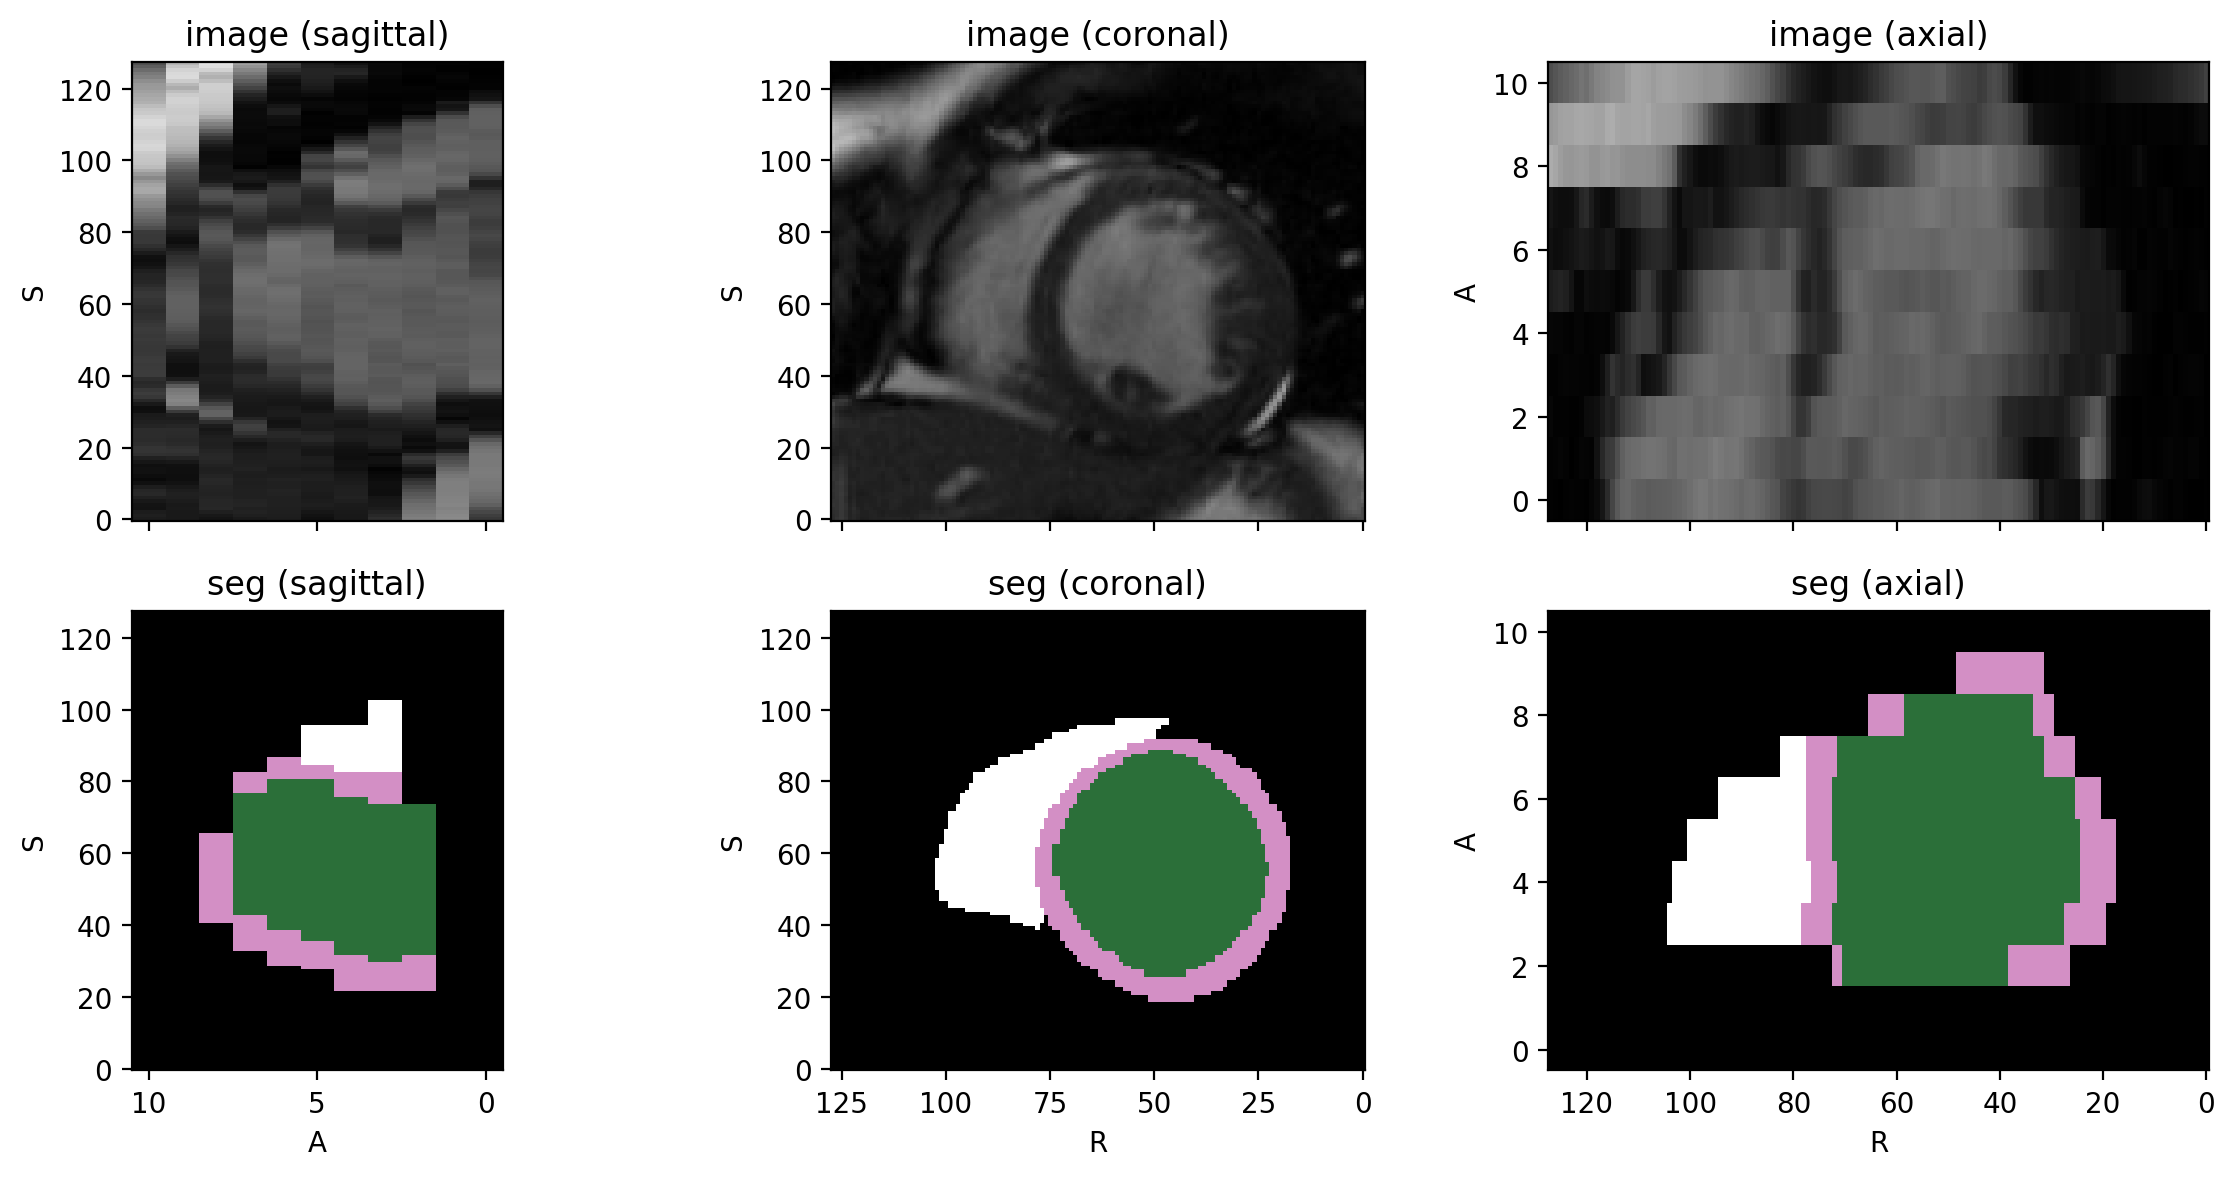

Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.13, 1.10, 10.00); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.13, 1.10, 10.00); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)


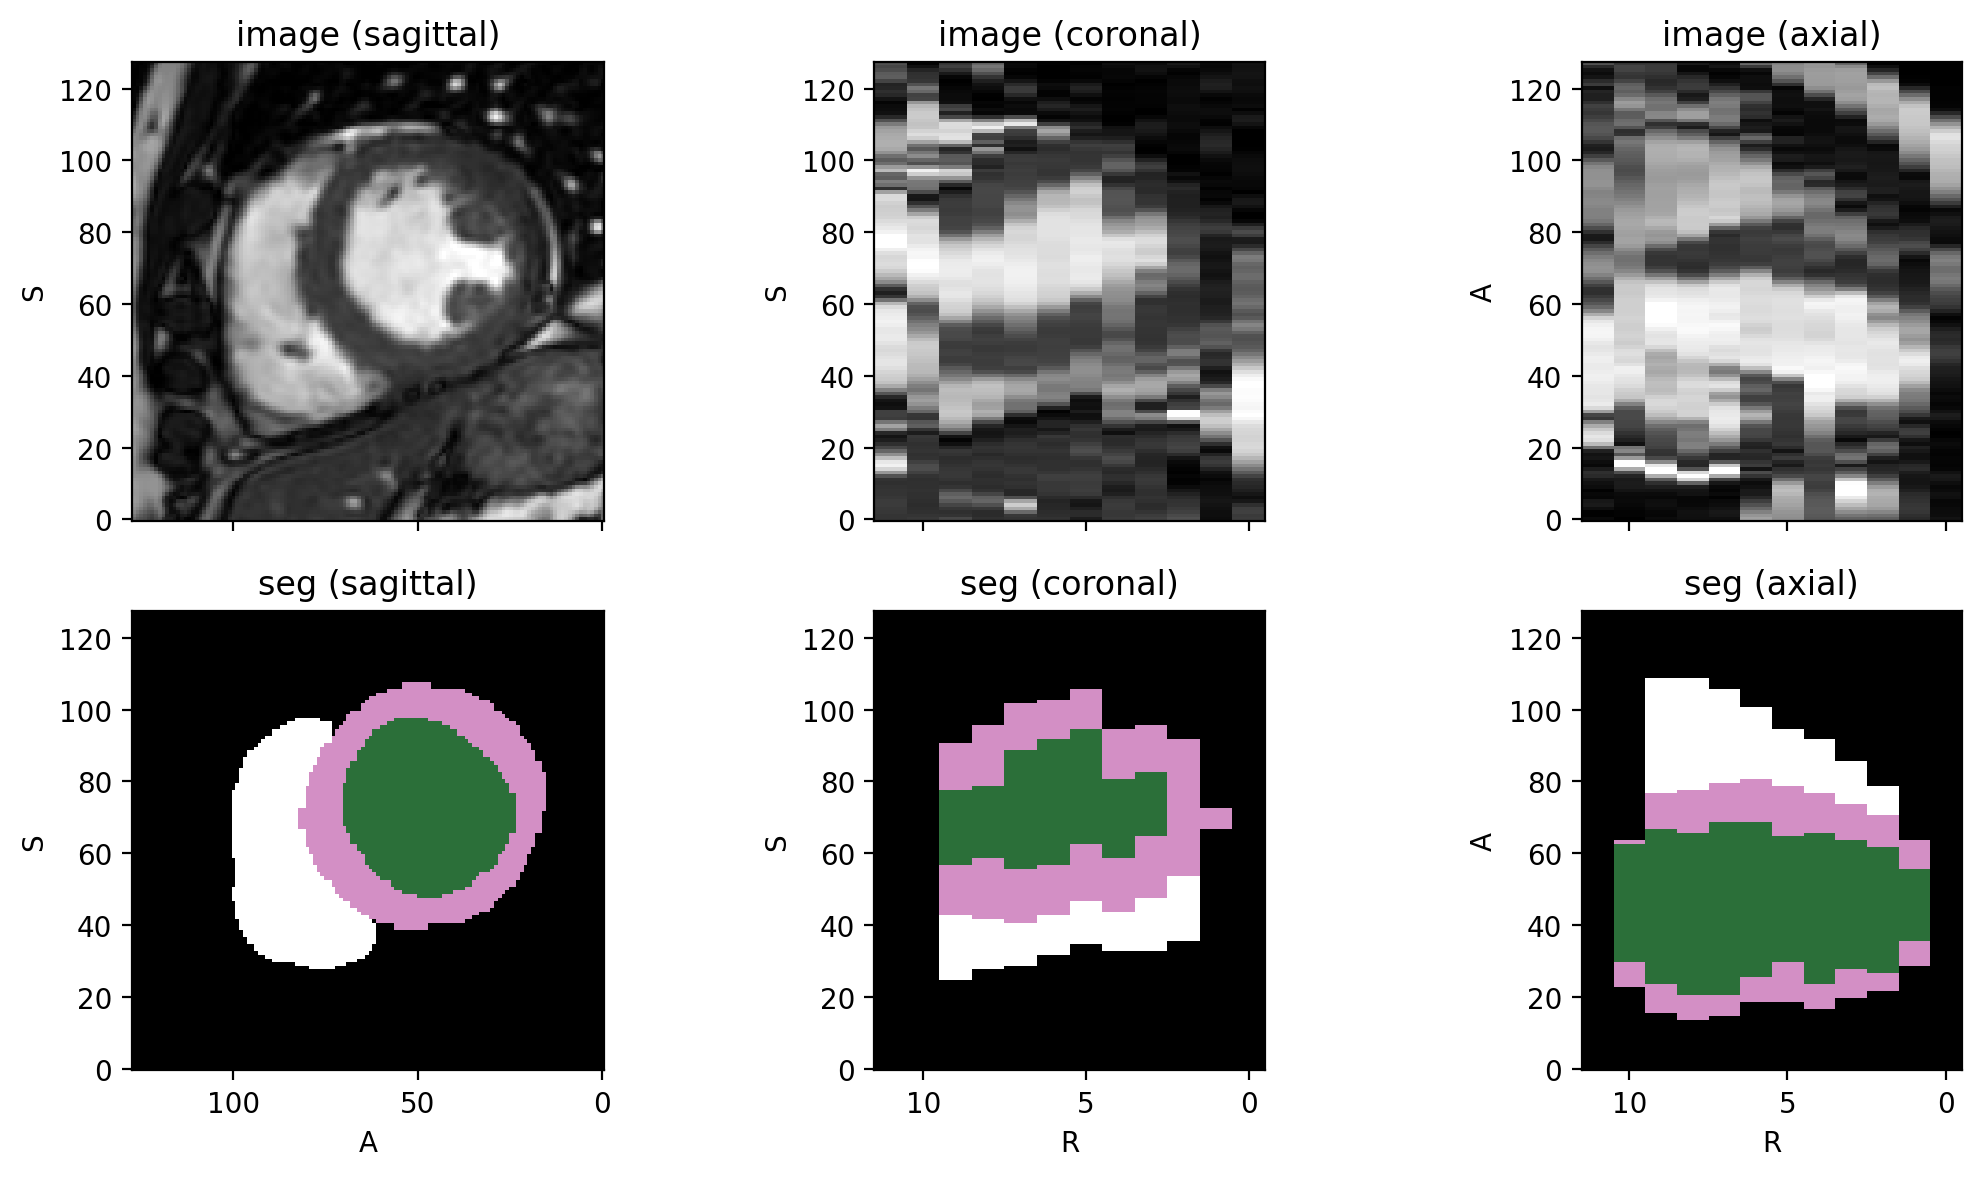

Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (0.99, 1.08, 9.60); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (0.99, 1.08, 9.60); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.5 MiB)


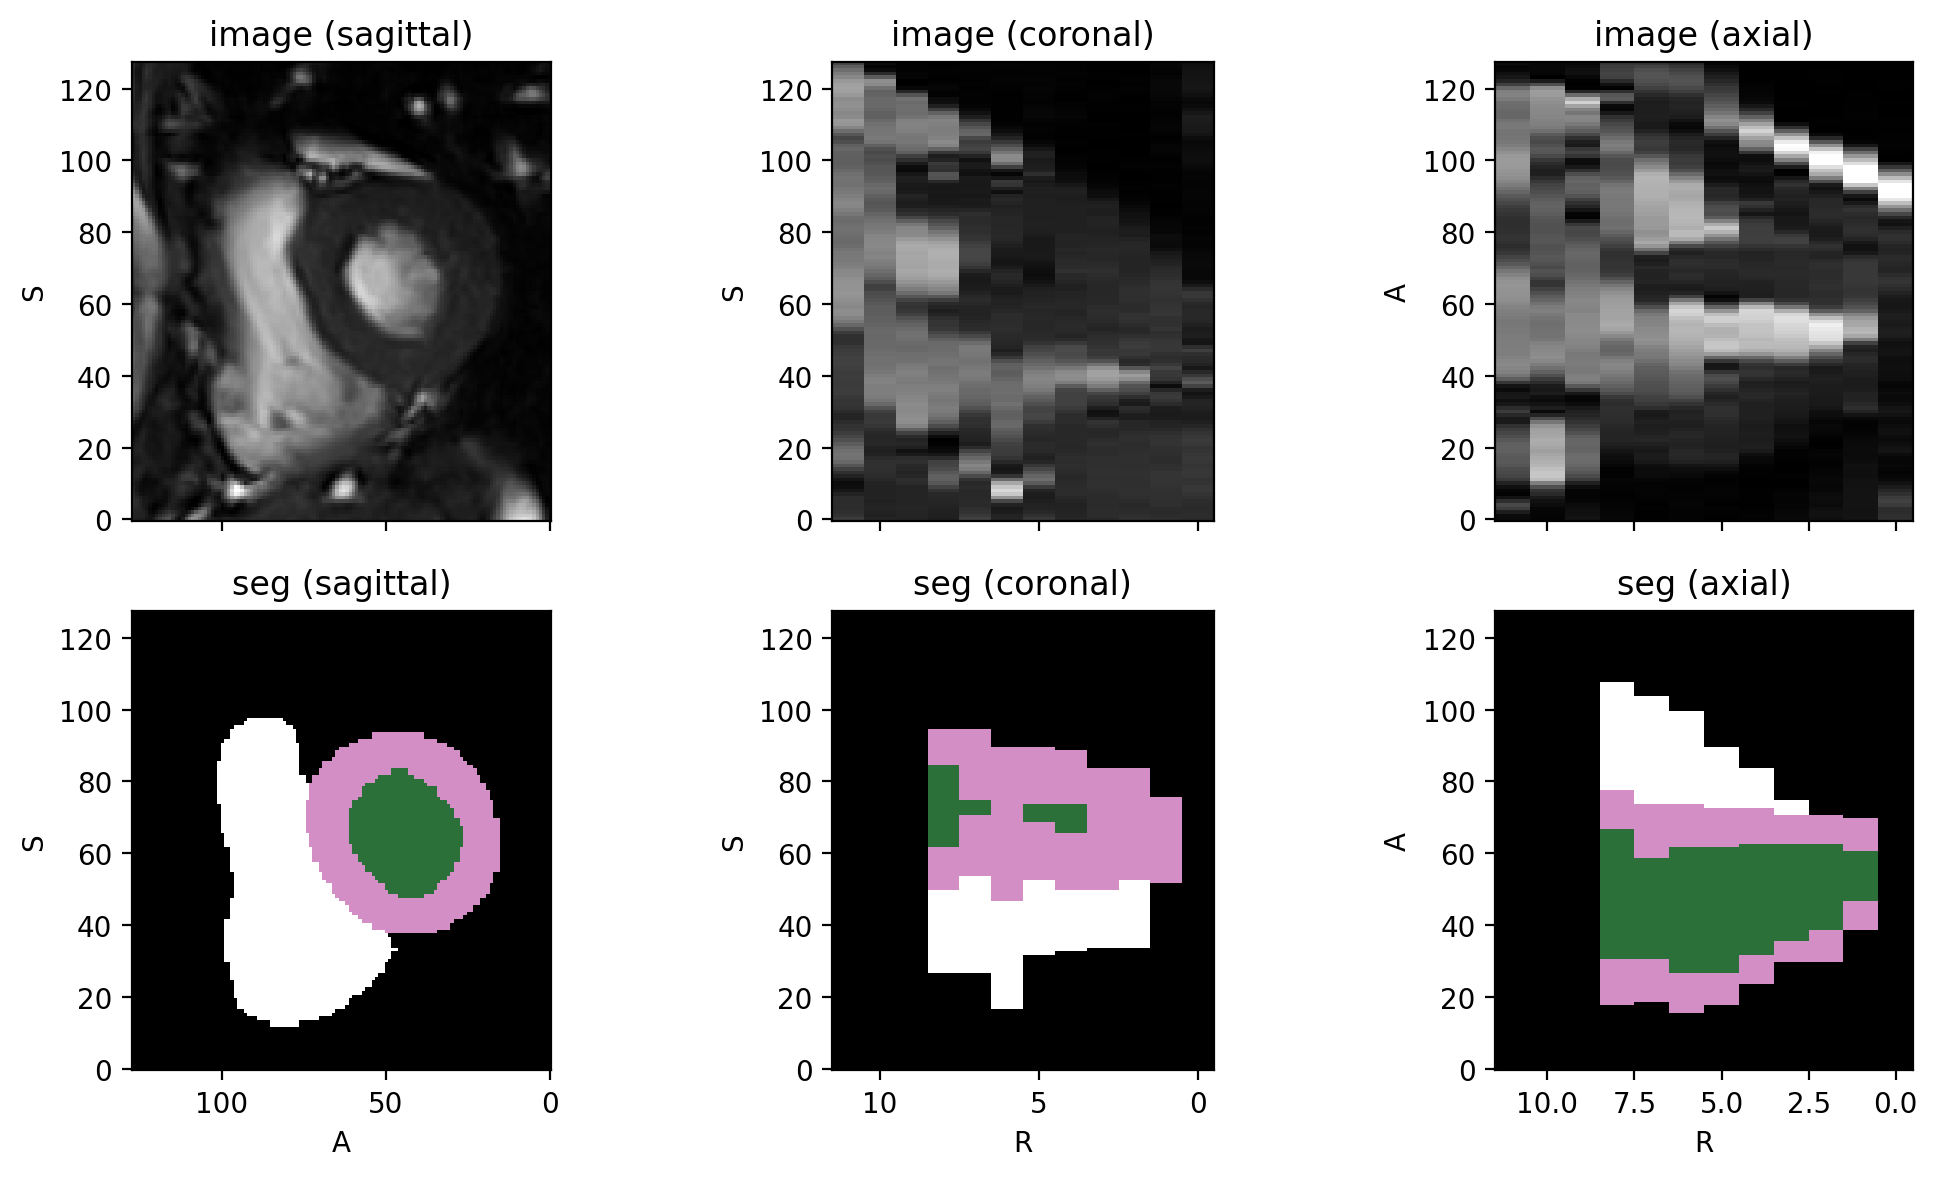

Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 14); spacing: (1.10, 0.85, 10.00); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.8 MiB)
LabelMap(shape: (2, 128, 128, 14); spacing: (1.10, 0.85, 10.00); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.8 MiB)


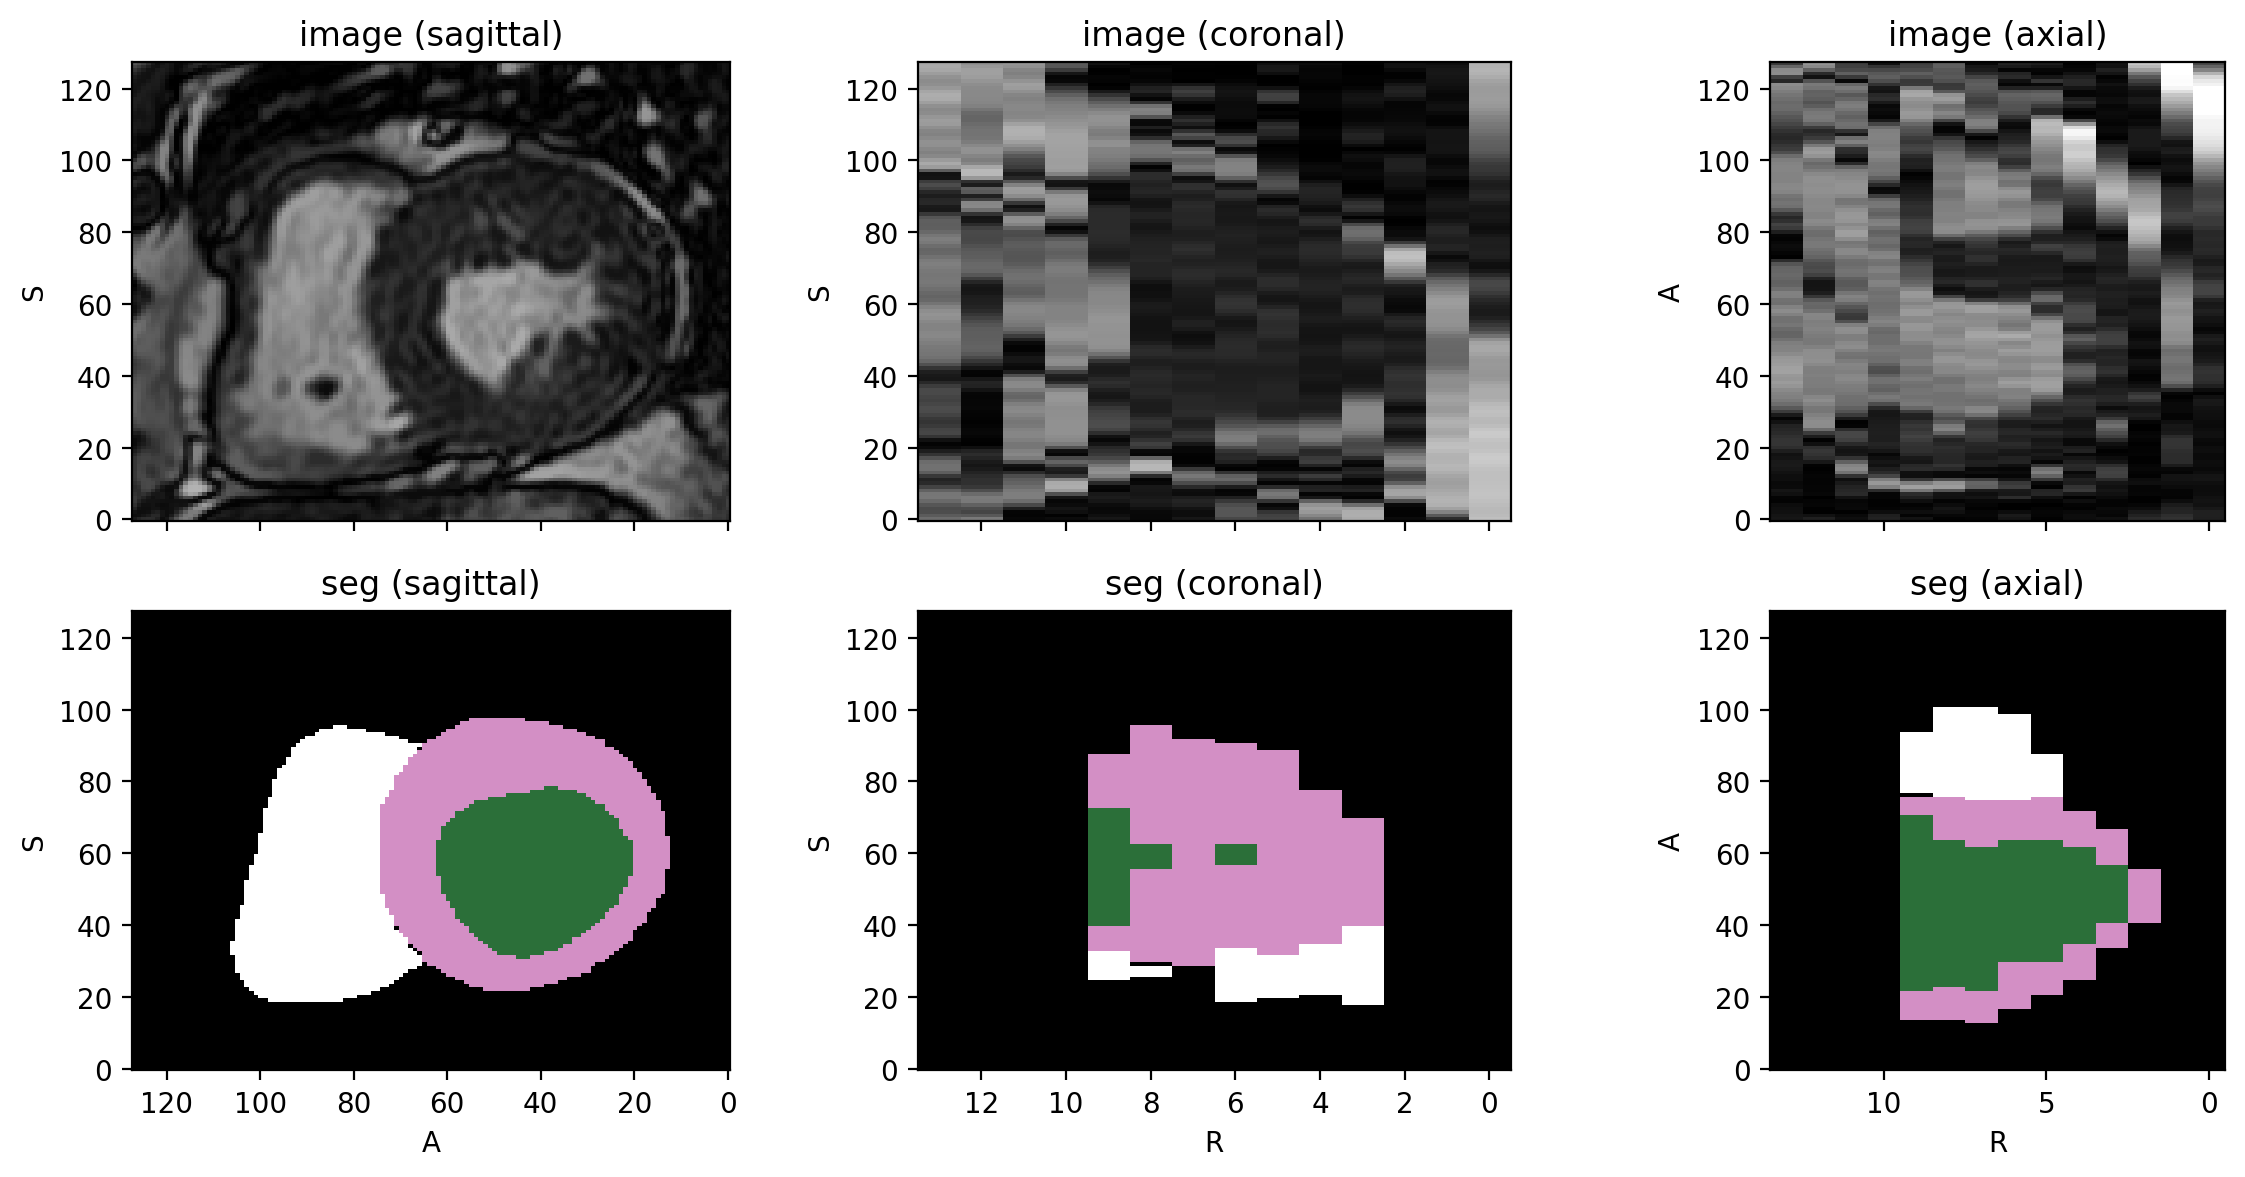

In [7]:
for i in range(4):
    visualize_subject(vendor_datasets_3D[i][0])

# Train on only one Vendor 

In [40]:
def initialize_model():
    model = UNet(
        in_channels=1,
        out_classes=4,
        dimensions=2,
        num_encoding_blocks=4,
        out_channels_first_layer=16,
        normalization='batch',
        upsampling_type='conv',
        padding=True,
        activation='PReLU'
    )

    optimizer = torch.optim.AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion


def load_model(model_name):
    model, optimizer, criterion = initialize_model()
    checkpoint = torch.load(f'models/{model_name}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    meta = checkpoint['metadata']
    num_epochs = meta['num_epochs']
    train_losses = meta['train_losses']
    valid_losses = meta['valid_losses']
    epoch = meta['epoch']

    return model, optimizer, num_epochs, train_losses, valid_losses, epoch


In [41]:
train_dataset = load_vendor_2D("F", metadata, transform)
valid_dataset = load_vendor_2D("A", metadata, transform)

print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(valid_dataset))

0it [00:00, ?it/s]

317it [00:07, 42.09it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 1770 subjects


317it [00:02, 156.47it/s]

Data/M&Ms/OpenDataset/ Dataset size: 442 subjects
Train dataset length: 1770
Validation dataset length: 442


In [29]:
torch.cuda.empty_cache()

In [42]:
num_epochs = (50)
batch_size = 16
num_classes = 4
num_workers = 10
save = True
model_name = f"Padding_{padding_size}"
save_best=True

model, optimizer, criterion = initialize_model()

model = train_model(model, 
                    optimizer, 
                    criterion,
                    device,  
                    train_dataset, 
                    valid_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    num_epochs=num_epochs,
                    verbose=3,
                    save=save,
                    model_name= model_name,
                    save_best=save_best
                    )

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:03<03:00,  3.69s/it]

Epoch [1/50]], Loss: 0.6740, Validation Loss: 0.4782


 22%|██▏       | 11/50 [00:38<02:14,  3.44s/it]

Epoch [11/50]], Loss: 0.0647, Validation Loss: 0.1955


 42%|████▏     | 21/50 [01:12<01:40,  3.46s/it]

Epoch [21/50]], Loss: 0.0367, Validation Loss: 0.1881


 62%|██████▏   | 31/50 [01:47<01:05,  3.45s/it]

Epoch [31/50]], Loss: 0.0277, Validation Loss: 0.2435


 82%|████████▏ | 41/50 [02:21<00:31,  3.45s/it]

Epoch [41/50]], Loss: 0.0293, Validation Loss: 0.2153


100%|██████████| 50/50 [02:52<00:00,  3.46s/it]


In [43]:
model, optimizer, criterion = initialize_model()
model, optimizer, num_epochs, train_losses, valid_losses, best_epoch = load_model(model_name)

Best epoch is: 11


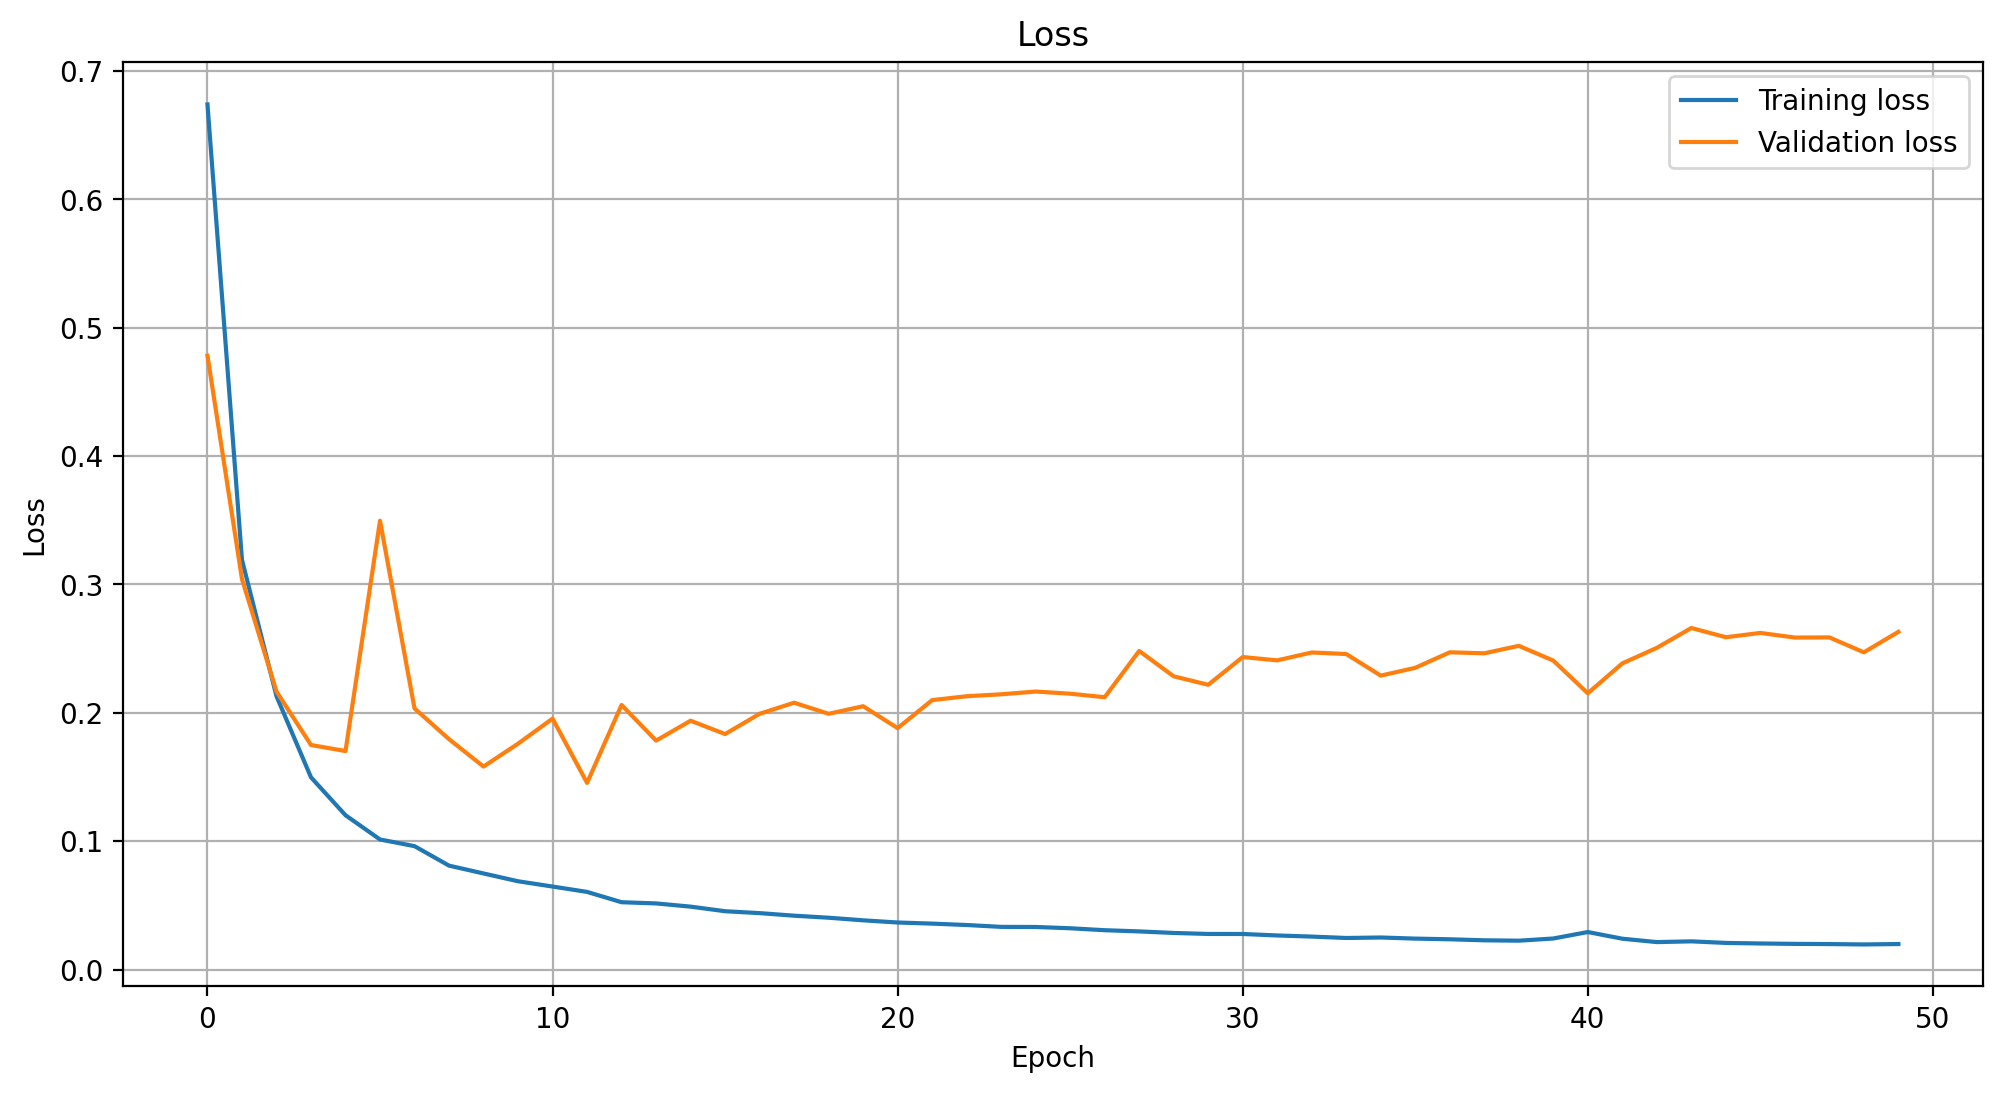

In [44]:
print("Best epoch is:", best_epoch)
plt.plot(range(num_epochs) , train_losses, label="Training loss")
plt.plot(range(num_epochs) , valid_losses, label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend()
plt.show()

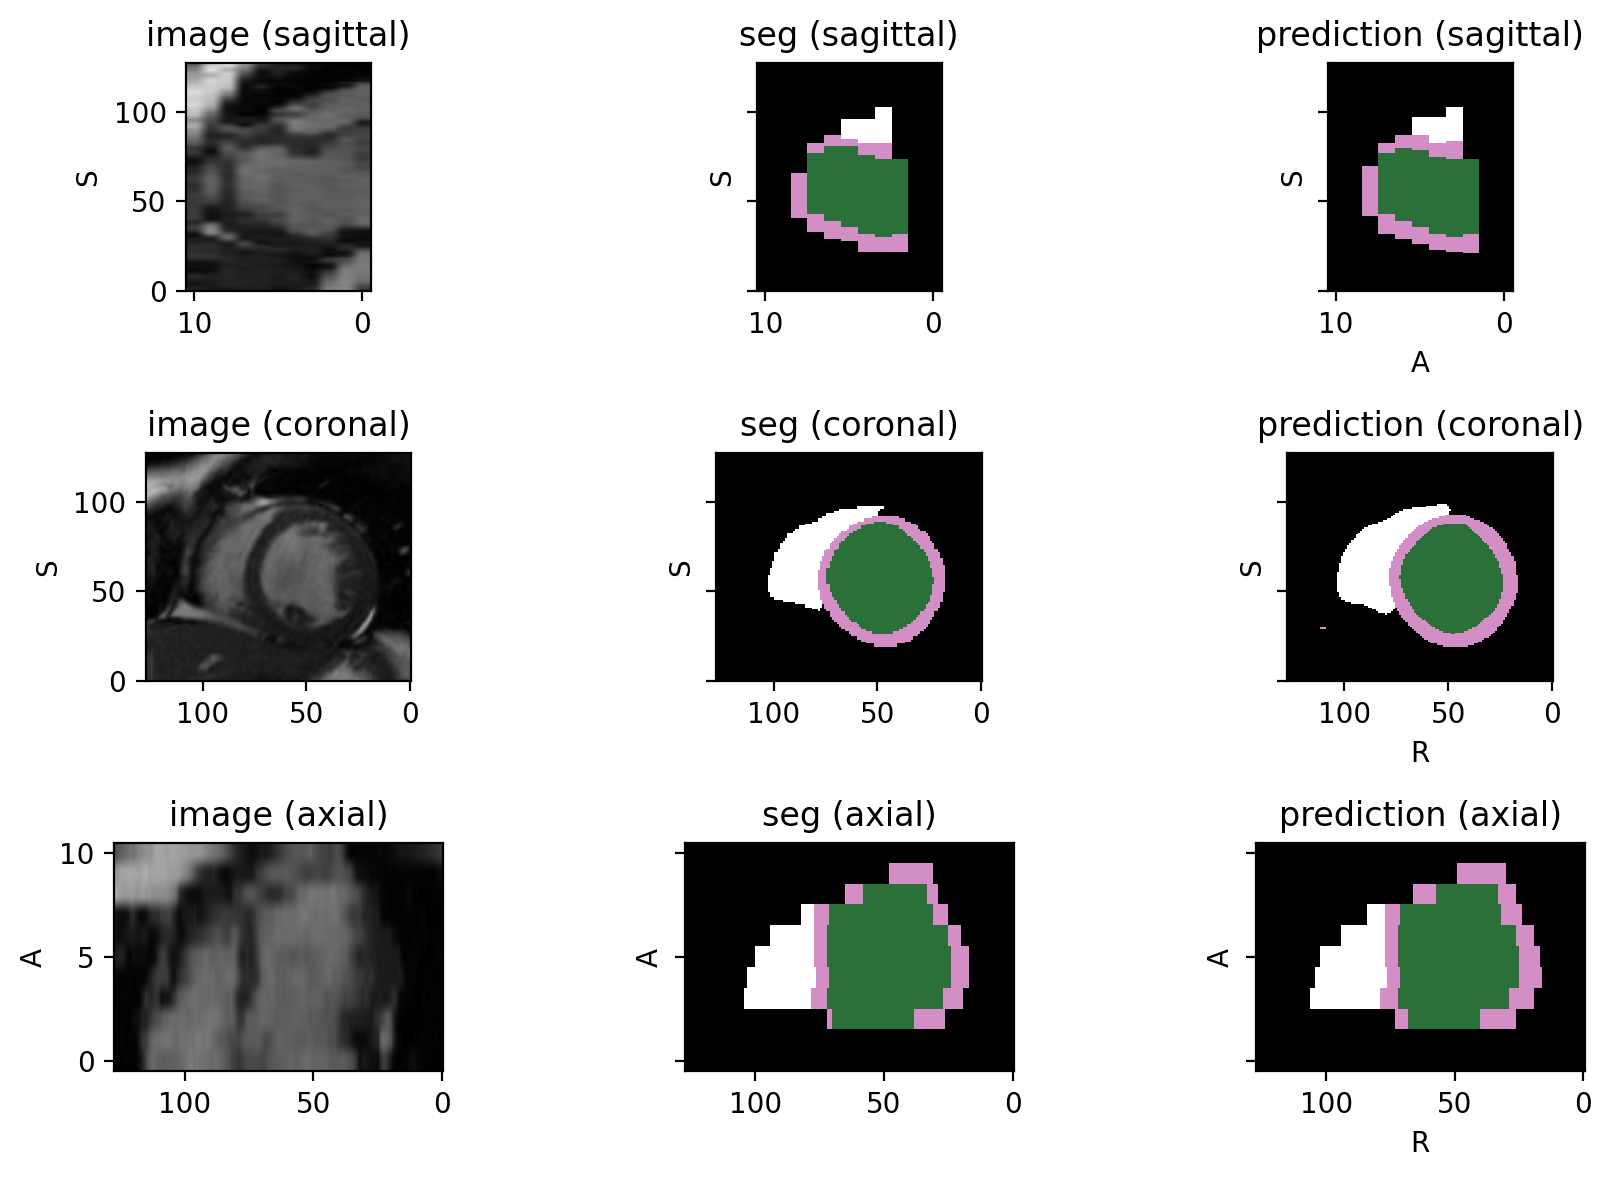

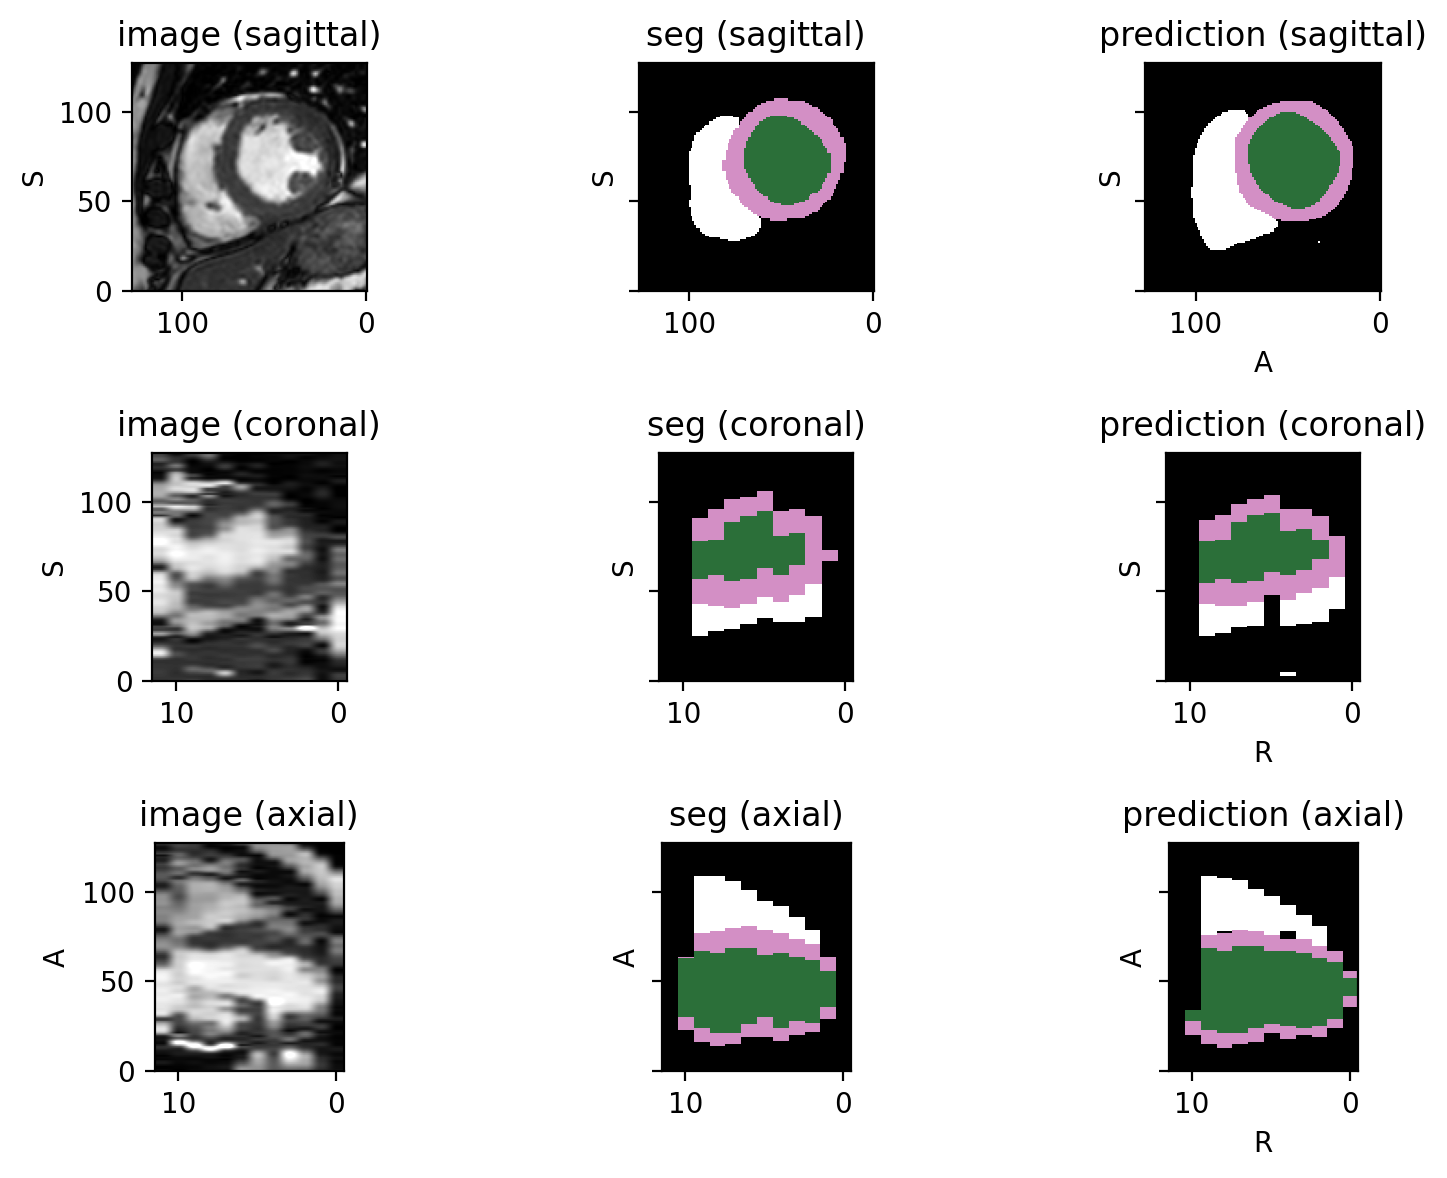

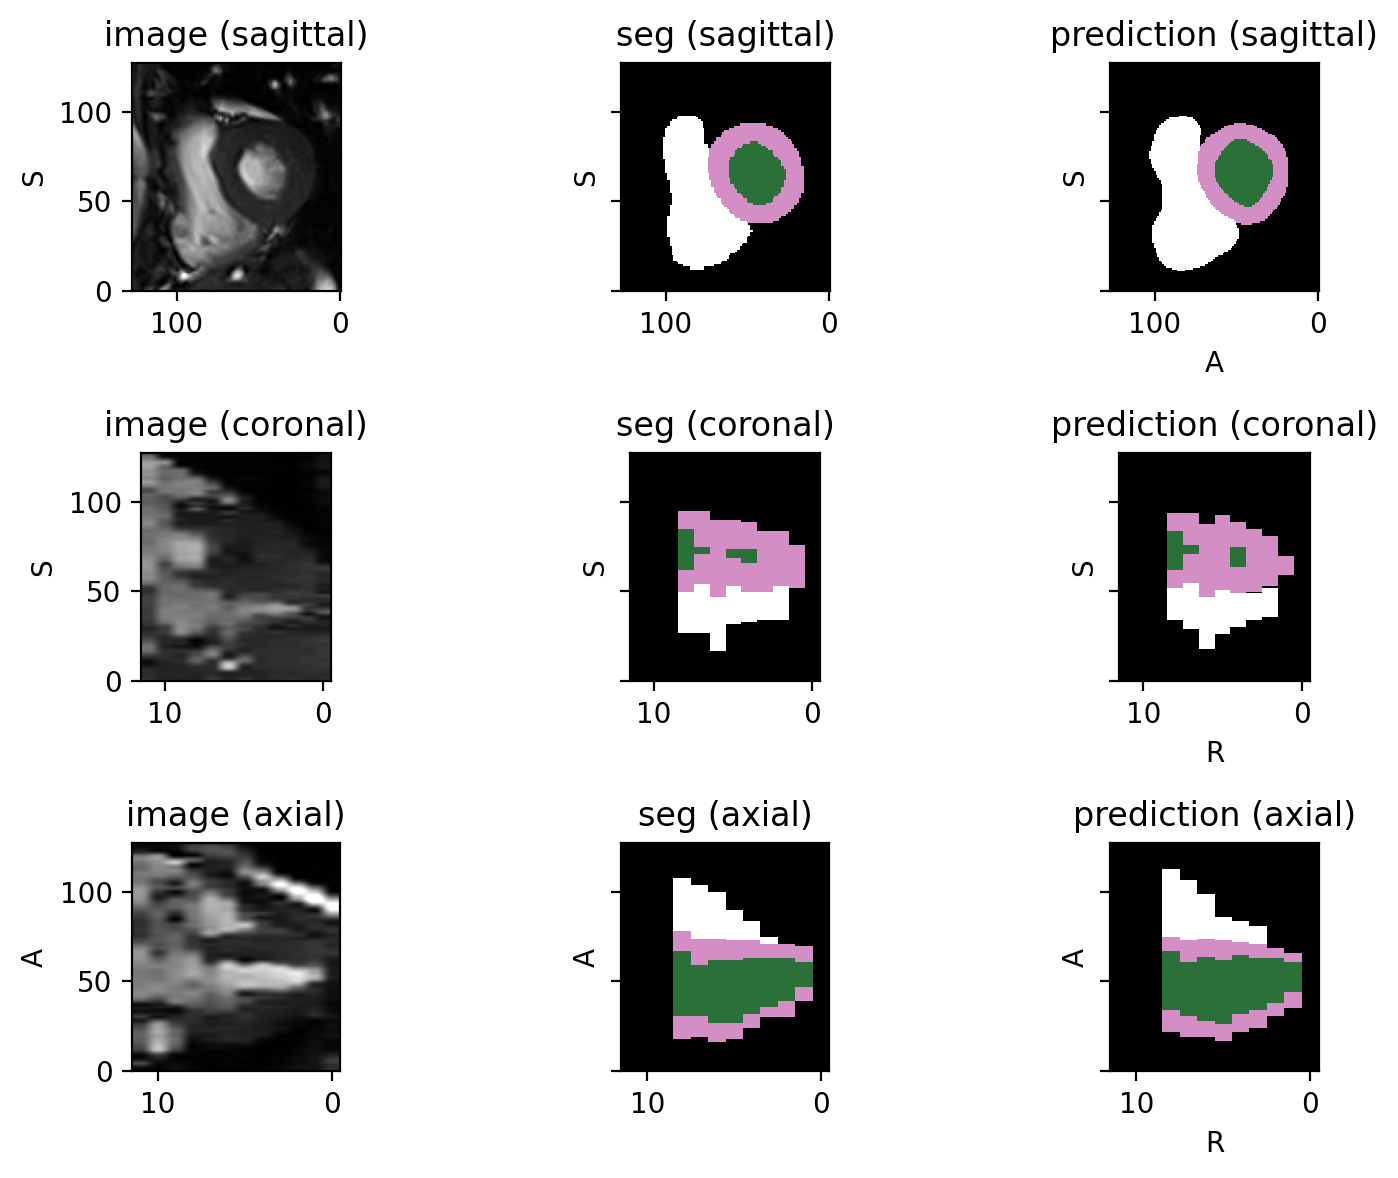

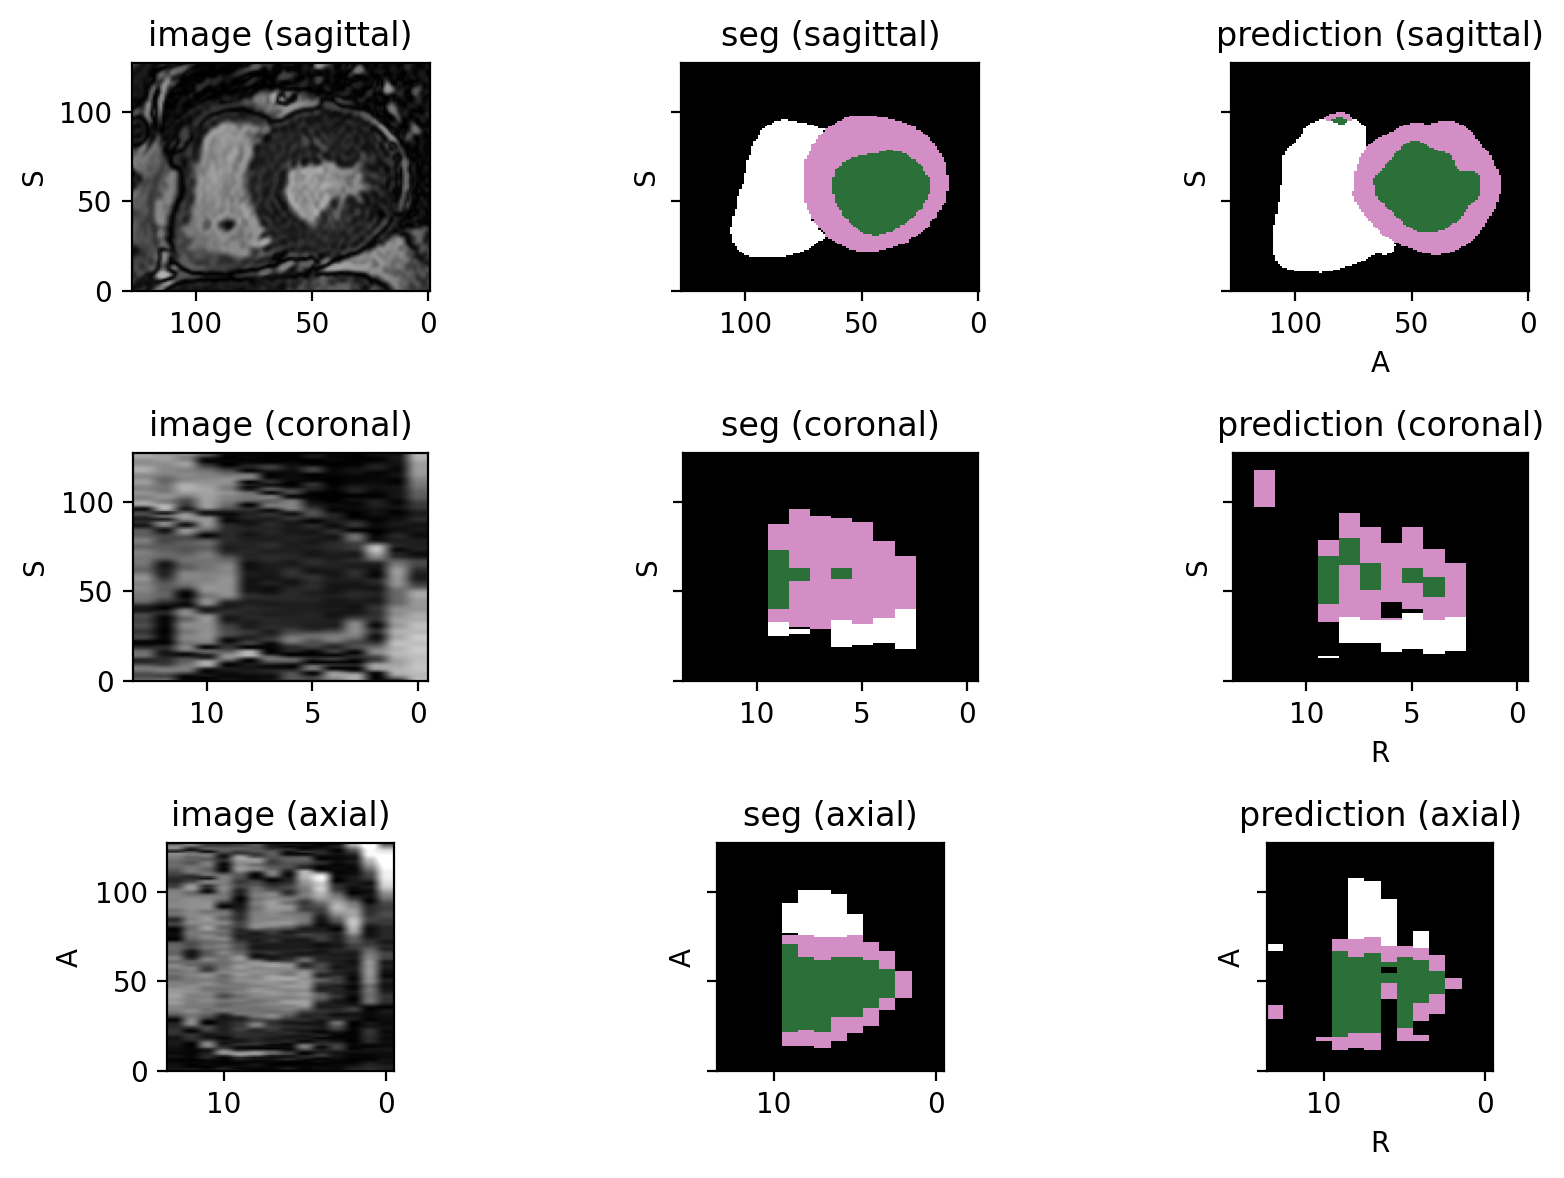

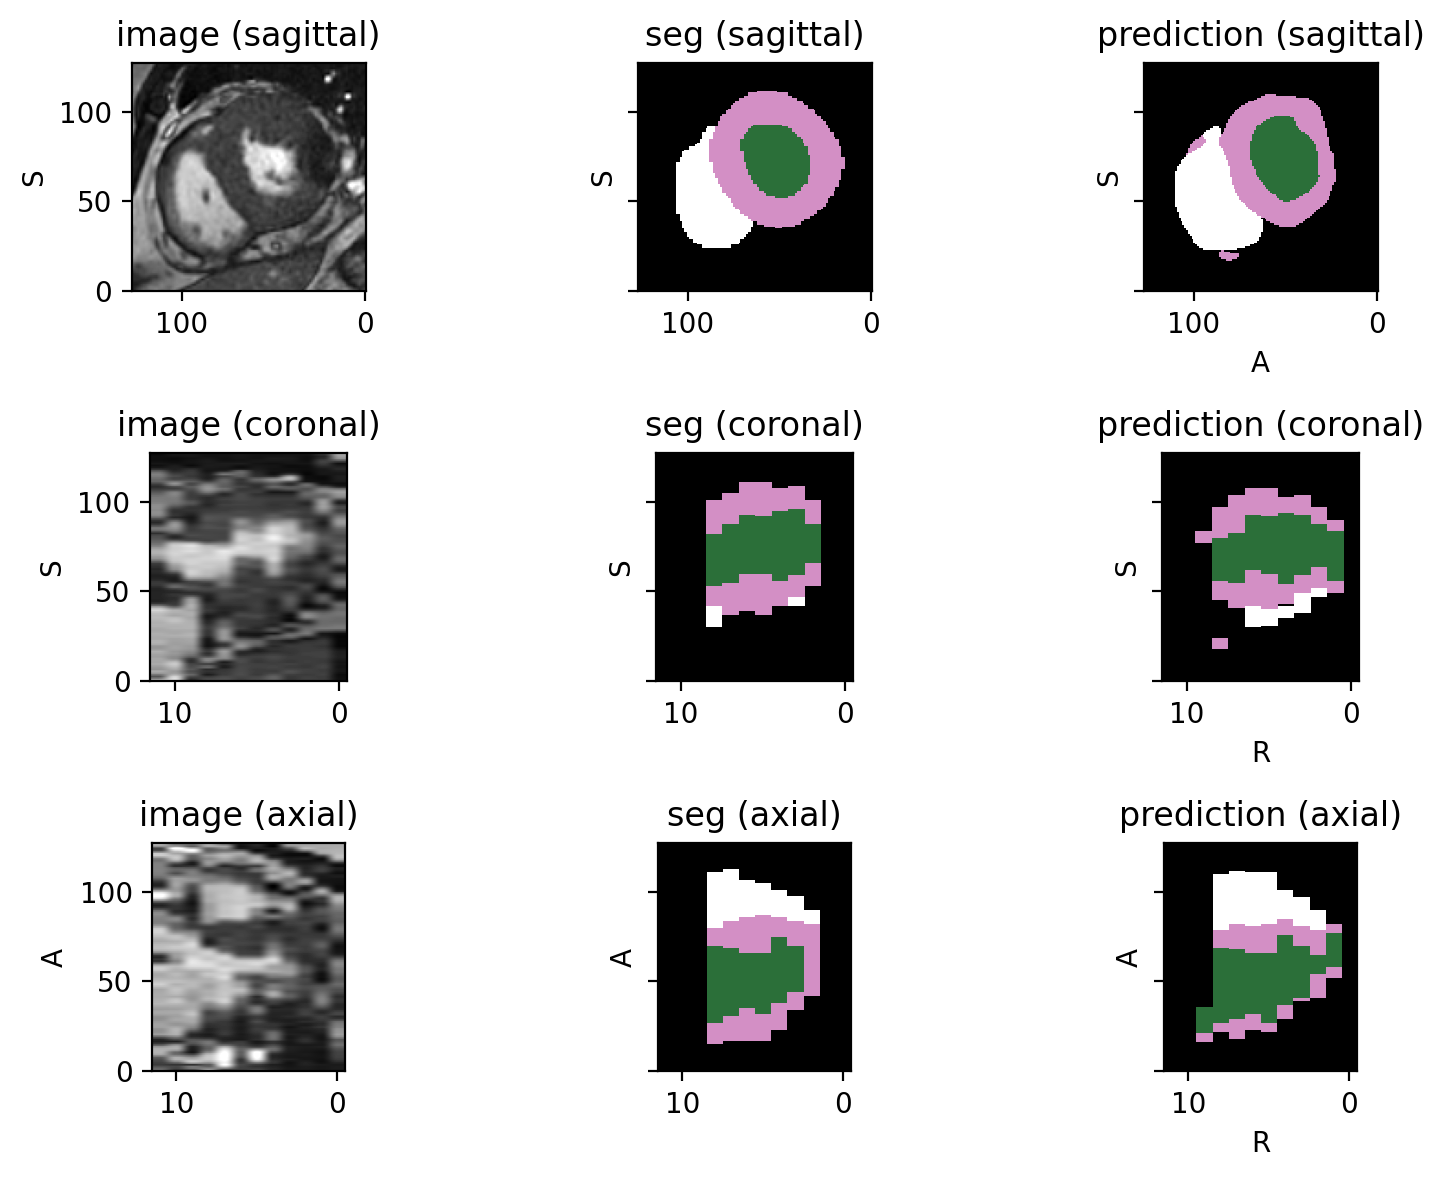

In [45]:
for i in range(len(vendors)):
    # Get data for one subject
    one_subject = vendor_datasets_3D[i][0]
    visualize_predictions_3D(model, one_subject, device)

In [46]:
results = metadata[['Vendor', 'Centre']].copy()

results = results.assign(Dice_BG_ED=None, Dice_LV_ED=None, Dice_MYO_ED=None, Dice_RV_ED=None)
results = results.assign(Dice_BG_ES=None, Dice_LV_ES=None, Dice_MYO_ES=None, Dice_RV_ES=None)

results = results.assign(IoU_BG_ED=None, IoU_LV_ED=None, IoU_MYO_ED=None, IoU_RV_ED=None)
results = results.assign(IoU_BG_ES=None, IoU_LV_ES=None, IoU_MYO_ES=None, IoU_RV_ES=None)

# results = results.assign(HD_BG_ED=None, HD_LV_ED=None, HD_MYO_ED=None, HD_RV_ED=None)
# results = results.assign(HD_BG_ES=None, HD_LV_ES=None, HD_MYO_ES=None, HD_RV_ES=None)


for dataset_3D in vendor_datasets_3D:
    for i in range(len(dataset_3D)):
        # Get data for one subject
        subject = dataset_3D[i]
        labels = subject.seg.data 
        id = subject.id
        vendor = metadata.loc[id].Vendor
        
        # Make predictions
        labels_stacked = labels.permute((0,3,1,2)).long()
        ed_labels = labels_stacked[0]
        es_labels = labels_stacked[1]


        predictions = predict_3D(model, subject, device)

        ed_predictions = predictions[:predictions.shape[0]//2]
        es_predictions = predictions[predictions.shape[0]//2:]

        # Run multi-class evaluation
        dc_ed = list(evaluate(ed_labels, ed_predictions, metric="Dice", multi_class=True, n_classes=4))
        dc_es = list(evaluate(es_labels, es_predictions, metric="Dice", multi_class=True, n_classes=4))

        jc_ed = list(evaluate(ed_labels, ed_predictions, metric="Jaccard", multi_class=True, n_classes=4))
        jc_es = list(evaluate(es_labels, es_predictions, metric="Jaccard", multi_class=True, n_classes=4))

        # hd_ed = list(evaluate(ed_labels, ed_predictions, metric="AHD", multi_class=T07/10/1964   
        results.loc[id, results.columns[2:]]  = dc_ed + dc_es + jc_ed + jc_es


results.to_csv(f'Results/{model_name}.csv', index=True)

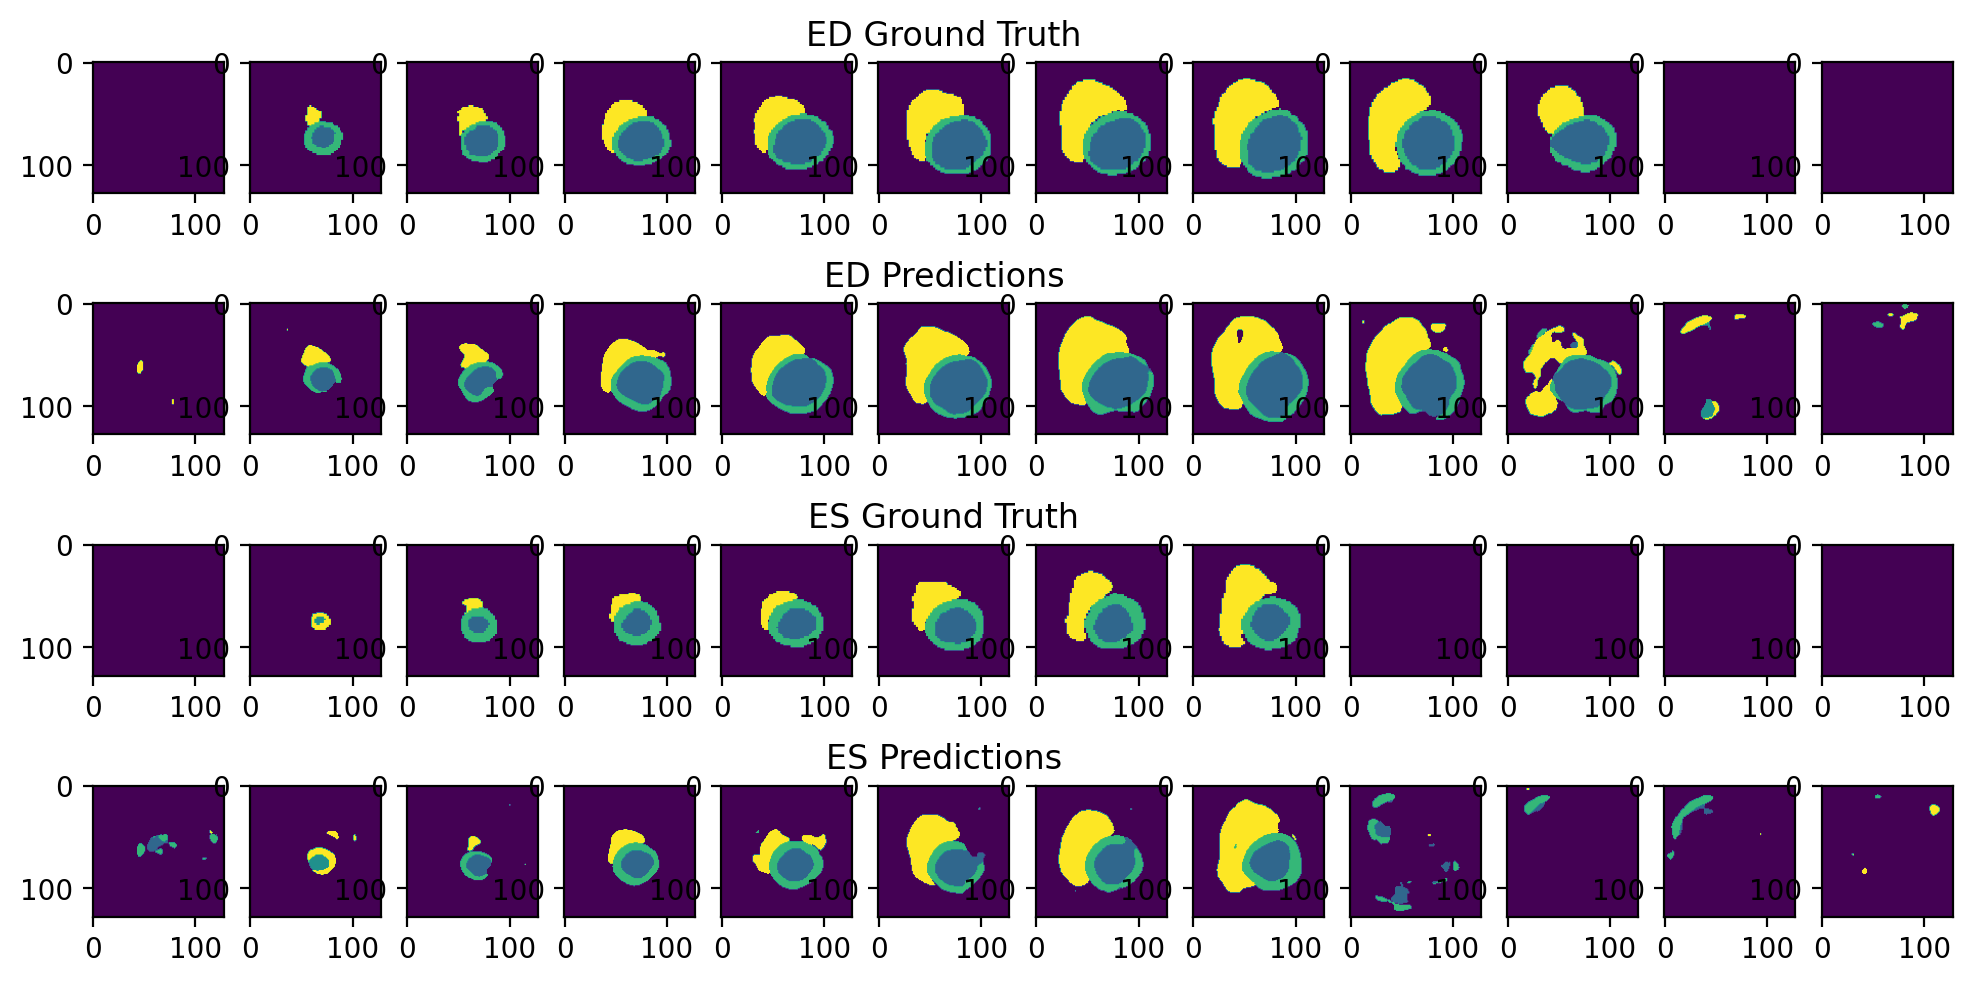

In [47]:
fig, axes = plt.subplots(4, 12)
axes[0, 5].set_title("ED Ground Truth")
axes[1, 5].set_title("ED Predictions")
axes[2, 5].set_title("ES Ground Truth")
axes[3, 5].set_title("ES Predictions")

for i in range(12):
    axes[0, i].imshow(ed_labels[i])
    axes[1, i].imshow(ed_predictions[i])
    axes[2, i].imshow(es_labels[i])
    axes[3, i].imshow(es_predictions[i])